<a href="https://colab.research.google.com/github/thalisrocha/pw-2-otimization-ml/blob/main/Computer_Lab_02_SDTSIA211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # <center> **SD-TSIA 211 Computer Lab** <center/>
# <center> Digit recognition <center/>


 <center> SANDRINI GUARACHO, Rafael <center/>
  <center> ROCHA PESTANA, Thalis <center/>

# Libraries import and data load

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import *
import matplotlib.pyplot as plt

11490434/11490434 [==============================] - 0s 0us/step
5


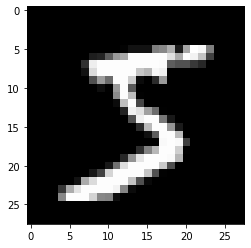

In [ ]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

5


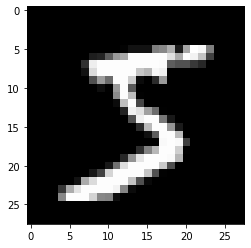

In [ ]:
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

# 4 - Model

In [ ]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


As we can see, the model has 26506 total params

In [ ]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

array([8, 3, 1, 3, 8, 3, 5, 3, 8, 8, 3, 1, 1, 8, 8, 8, 8, 1, 8, 8, 8, 1,
       8, 1, 1, 1, 8, 3, 8, 8, 8, 3, 8, 7, 8, 1, 8, 8, 5, 8, 8, 3, 7, 8,
       1, 8, 8, 1, 8, 3, 8, 3, 8, 1, 8, 3, 3, 1, 8, 1, 8, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 8, 8, 8, 8, 8, 1, 1, 3, 8, 7, 8, 3, 1, 3, 8, 3, 3, 7,
       8, 8, 8, 8, 1, 3, 3, 8, 7, 3, 8, 8])

In [ ]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

# 5 - Stochastic gradient descent

In [ ]:
## Update weights function
def update_weights(model, update, gama):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] - (gama*update[i])
    model.set_weights(new_weights)

In [ ]:
# Stochastic gradient algorithm
def sgd(model, loss, x_train, y_train, K):
  gama = 1/np.sqrt(K) #step size (as we know the K number of iterations, we can use this constant step size)
  lossValues = [] #array to append our loss values, that will be calculated with the whole DB every 1000 iterations
  for i in range(K):
    if (i%1000 == 0):
      logits = model(x_train)
      loss_value = loss(y_train, logits)
      lossValues.append(loss_value)
    e = randint(0,K-1) #picking a random position for our 1-batch sgd
    x_train_batch = x_train[e].reshape(-1,784)
    y_train_batch = y_train[e]

    with tf.GradientTape() as tape:
            logits = model(x_train_batch)
            loss_value = loss(y_train_batch, logits)

    grad = tape.gradient(loss_value, model.trainable_weights)
    update_weights(model, grad, gama)
  return lossValues

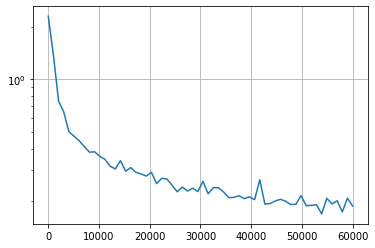

In [ ]:
lossValues = sgd(model, loss, x_train, y_train, 60000)
x = np.linspace(0,60000,60)
plt.grid()
plt.semilogy(x,lossValues)

# 6 - Empirical risk minimization


In [ ]:
def gst(batch, epochs, model, loss, x_train, y_train, K):
  losses = []
  gama = 1/np.sqrt(K) #step size (same explanation)
  for j in range(epochs):
    for i in range(K//batch):
      x_train_batch = x_train[i*batch:(i+1)*batch].reshape(-1,784)
      y_train_batch = y_train[i*batch:(i+1)*batch]

      with tf.GradientTape() as tape:
            logits = model(x_train_batch)
            loss_value = loss(y_train_batch, logits)

      grad = tape.gradient(loss_value, model.trainable_weights)
      update_weights(model, grad, gama)

      e = np.random.randint(0, 5999, 1000)

      logits = model(x_train[e])
      loss_value = loss(y_train[e], logits).numpy()
      losses.append(loss_value)

  return losses

Now we will run our algorithm for different batch and epoch sizes (We need to reload the Model in the 4th cell):

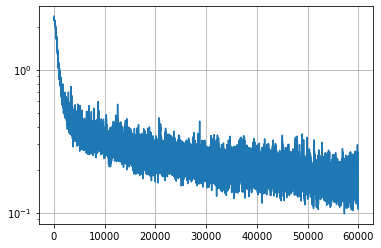

In [ ]:
losses = gst(1, 1, model, loss, x_train, y_train, 60000)
x = np.linspace(0,60000,len(losses))
plt.grid()
plt.semilogy(x,losses)

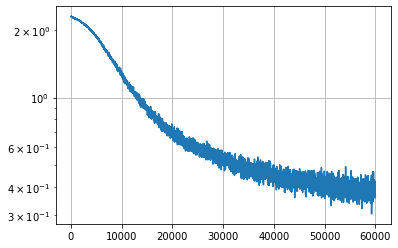

In [ ]:
losses = gst(15, 1, model, loss, x_train, y_train, 60000)
x = np.linspace(0,60000,len(losses))
plt.grid()
plt.semilogy(x,losses)

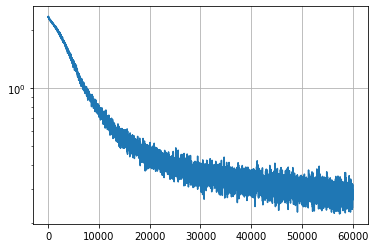

In [ ]:
losses = gst(64, 10, model, loss, x_train, y_train, 60000)
x = np.linspace(0,60000,len(losses))
plt.grid()
plt.semilogy(x,losses)

This scheme can provide a faster and more efficient process than stochastic gradient descent because not all training data is applied. However, it needs a reasonable number of batchs in order to reduce the oscillation in the individual component of the gradient.